In [ ]:
from __future__ import print_function
import os, cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from tqdm import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

batchSize = 30

In [24]:
# Read data
trainData = datasets.ImageFolder(os.path.join(os.getcwd(), "Dataset_OpenCvDl_Hw2_Q5", "training_dataset"), transform=transform)
validData = datasets.ImageFolder(os.path.join(os.getcwd(), "Dataset_OpenCvDl_Hw2_Q5", "validation_dataset"), transform=transform)
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=batchSize, shuffle=True)
validLoader = torch.utils.data.DataLoader(validData, batch_size=batchSize, shuffle=True)
print(trainData.class_to_idx)

{'Cat': 0, 'Dog': 1}


In [25]:
model = torchvision.models.resnet50(pretrained=True)

for params in model.parameters():
    params.requires_grad_ = False
nrFilters = model.fc.in_features
model.fc = nn.Linear(nrFilters, 1)

model = model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [28]:
epochNum = 10

optimizer = optim.Adam(model.fc.parameters())
lossFunc = nn.BCEWithLogitsLoss()

trainAcces, validAcces = list(), list()

def saveModel():
    path = os.path.join(os.getcwd(), "model.pth")
    torch.save(model.state_dict(), path)

def validAccuracy():
    correct, total = 0, 0  # correct: 預測正確的個數, total: 總共預測個數
    
    with torch.no_grad():
        for images, labels in validLoader:
            images = images.to(device)
            labels = labels.unsqueeze(1).float()
            labels = labels.to(device)
            
            model.eval()
            outputs = model(images)
            total += labels.size(0)
            predicts = [0 if x < 0.5 else 1 for x in outputs.detach().cpu().numpy().ravel()]
            correct += len(predicts == labels.detach().cpu().numpy().ravel())

    accuracy = 100 * correct / total
    return accuracy
            
def train():
    print("Device: ", device)
    bestAcc = 0.0
    
    for epoch in range(epochNum):
        print("Epoch num:", epoch+1)
        lossTotal = 0.0
        correct, total = 0, 0
        
        for i, (images, labels) in enumerate(tqdm(trainLoader)):
            images = images.to(device)
            labels = labels.unsqueeze(1).float()
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            model.train()
            loss = lossFunc(outputs, labels)
            lossTotal += loss.item()
            
            loss.backward()
            optimizer.step()
            
            total += labels.size(0)
            predicts = [0 if x < 0.5 else 1 for x in outputs.detach().cpu().numpy().ravel()]
            correct += len(predicts == labels.detach().cpu().numpy().ravel())

        # Compute train and validation accuracy
        trainAcc = 100 * correct / total
        validAcc = validAccuracy()
        trainAcces.append(trainAcc)
        validAcces.append(validAcc)
        lossAvg = lossTotal / (total / batchSize)
        
        print("The loss of training set is %.3f" % (lossAvg))
        print("The training accuracy is %d %%" % (trainAcc))
        print("The validation accruacy is %d %%" % (validAcc))
        print()
        
        # save model
        if validAcc > bestAcc:
            saveModel()
            bestAcc = validAcc
            
train()

Device:  cuda:0


100%|█████████████████████████████████████████| 540/540 [01:32<00:00,  5.85it/s]


Epoch num: 1
The loss of training set is 0.050
The training accuracy is 100 %
The validation accruacy is 100 %



100%|█████████████████████████████████████████| 540/540 [01:31<00:00,  5.87it/s]


Epoch num: 2
The loss of training set is 0.048
The training accuracy is 100 %
The validation accruacy is 100 %



100%|█████████████████████████████████████████| 540/540 [01:32<00:00,  5.86it/s]


Epoch num: 3
The loss of training set is 0.051
The training accuracy is 100 %
The validation accruacy is 100 %



100%|█████████████████████████████████████████| 540/540 [01:33<00:00,  5.77it/s]


Epoch num: 4
The loss of training set is 0.043
The training accuracy is 100 %
The validation accruacy is 100 %



100%|█████████████████████████████████████████| 540/540 [01:34<00:00,  5.74it/s]


Epoch num: 5
The loss of training set is 0.049
The training accuracy is 100 %
The validation accruacy is 100 %



100%|█████████████████████████████████████████| 540/540 [01:33<00:00,  5.78it/s]


Epoch num: 6
The loss of training set is 0.049
The training accuracy is 100 %
The validation accruacy is 100 %



100%|█████████████████████████████████████████| 540/540 [01:34<00:00,  5.72it/s]


Epoch num: 7
The loss of training set is 0.040
The training accuracy is 100 %
The validation accruacy is 100 %



100%|█████████████████████████████████████████| 540/540 [01:34<00:00,  5.70it/s]


Epoch num: 8
The loss of training set is 0.047
The training accuracy is 100 %
The validation accruacy is 100 %



100%|█████████████████████████████████████████| 540/540 [01:35<00:00,  5.64it/s]


Epoch num: 9
The loss of training set is 0.039
The training accuracy is 100 %
The validation accruacy is 100 %



100%|█████████████████████████████████████████| 540/540 [01:35<00:00,  5.67it/s]


Epoch num: 10
The loss of training set is 0.044
The training accuracy is 100 %
The validation accruacy is 100 %



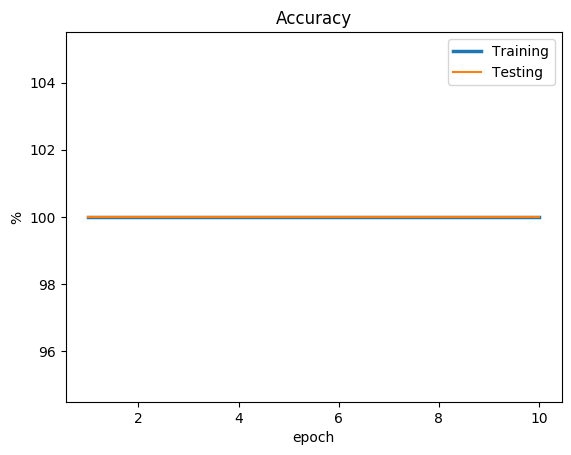

In [36]:
def plot(trainAcc, testAcc):
    # Accuracy plt
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("%")
    numLst = list( range(1, len(trainAcc)+1) )
    plt.plot(numLst, trainAcc, label="Training", linewidth=2.5)
    plt.plot(numLst, testAcc, label="Testing")
    plt.legend()
    
    plt.savefig("Acc.png")
    plt.show()
    
plot(trainAcces, validAcces)

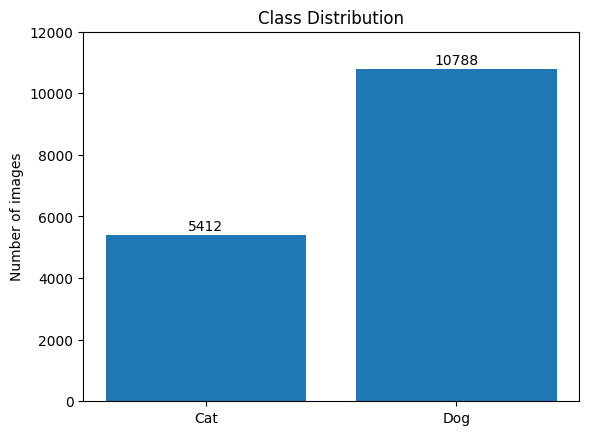

In [9]:
# Plot training dataset distrubution
path = os.path.join(os.getcwd(), "")
catLen = len( os.listdir( os.path.join(os.getcwd(), "Dataset_OpenCvDl_Hw2_Q5", "training_dataset", "Cat") ) )
dogLen = len( os.listdir( os.path.join(os.getcwd(), "Dataset_OpenCvDl_Hw2_Q5", "training_dataset", "Dog") ) )

x = ["Cat", "Dog"]
y = [catLen, dogLen]
plt.ylabel("Number of images")
plt.ylim(0, 12000)
plt.title("Class Distribution")
dtb = plt.bar(x, y)

for idx, cLen in enumerate(y):
    plt.text(idx, cLen+50, str(cLen), ha="center", va="bottom")

plt.savefig("distribution.png")
plt.show()